# Setup

If you haven't already please install mallet. As that will be required to run the following notebook. There is also a back up alterative lda model we will allow usage of (LDA Multicore). 

[Installation of Mallet](http://www.themacroscope.org/?page_id=799)

### Pre Processing

In [1]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

We have filtered all news headlines from Reuters from 2014 to 2016 by checking for the occurence of the word 'oil'. We then aggregate file corpus into a line corpus, provided as a CSV file ('WTI-NEWS.csv'). We have functions in our Python script that will read this in and perform the following pre-processing steps:

- Remove Stop Words (NLTK) 
- Lower Case (Gensim) 
- Remove Punctuation (Gensim) 
- Remove Numbers (Gensim) 
- Stemmed/Lemmatized (NLTK) 

After this we use the bag of words approach and build up a corpus of pre-processed documents. This is all done by invoking the get_text_data() method.

In [34]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

In [2]:
from CTADaily import get_text_data
text_df, dictionary, corpus = get_text_data('WTI-NEWS.csv', 'Headline')

C:\Users\Yash\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
text_df.head(2)

,Date,Headline
0,2014-01-02,"[brazil, oleo, gas, say, honor, oil, field, debt]"
1,2014-01-02,"[cabot, oil, gas, corpor, declar, dividend]"


### Building The Model

In [4]:
from CTADaily import build_lda_model
lda_model = build_lda_model('Mallet', corpus, dictionary, num_topics=10)

If you were unable to install Mallet, there is an alternative model type you can use which is the LDA Multicore method from gensim. This can be simply passed into build_lda_model as follows:

In [5]:
#lda_model = build_lda_model('Multicore', corpus, dictionary, num_topics=10)

#### Optimizing Model by Coherence

In [6]:
from gensim.models.coherencemodel import CoherenceModel
from CTADaily import get_tokens 

tokens = get_tokens(text_df, 'Headline')

cm = CoherenceModel(model=lda_model, corpus=corpus, texts=tokens, coherence='c_v')
coherence = cm.get_coherence()
print(coherence)

0.37959492487006535


We see quite a low coherence value of 0.38 for 20 topics. Let's try to optimise this.

In [27]:
from CTADaily import get_coherence_scores
models, scores = get_coherence_scores(tokens, corpus, dictionary, range(1, 60, 10))

Building Model with 1 #Topics
Coherence 0.1532535840128281
Building Model with 2 #Topics
Coherence 0.25021754159673515
Building Model with 3 #Topics
Coherence 0.3520933012191949
Building Model with 4 #Topics
Coherence 0.44989719375537823
Building Model with 5 #Topics
Coherence 0.43226272533534127
Building Model with 6 #Topics
Coherence 0.3983602067041176
Building Model with 7 #Topics
Coherence 0.3901022374425521
Building Model with 8 #Topics
Coherence 0.3732385538372965
Building Model with 9 #Topics
Coherence 0.3995953241000658


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

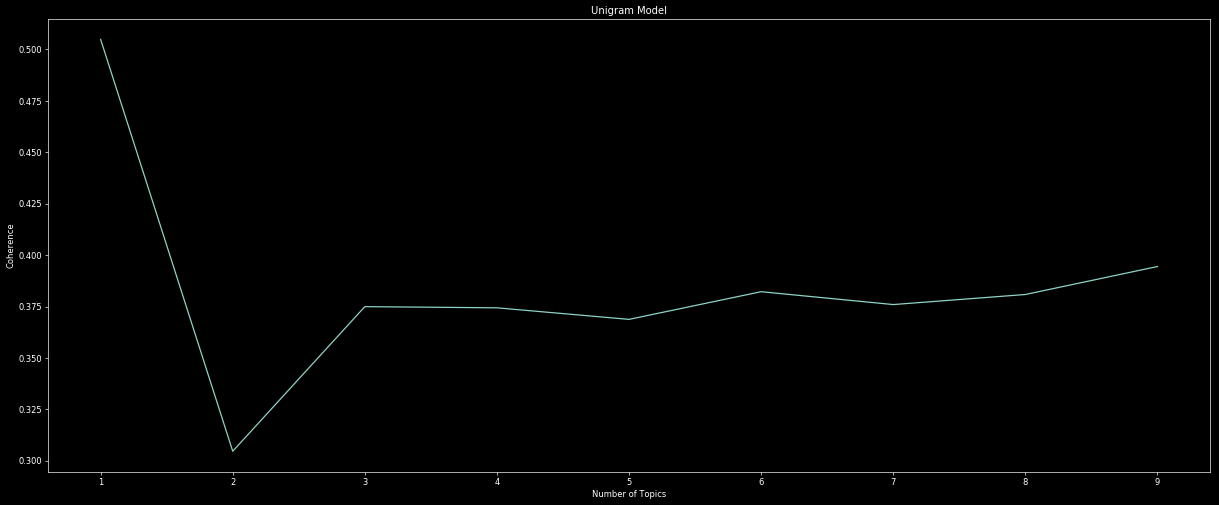

In [114]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 10), dpi= 60)
fig = plt.plot(range(1, 60, 10), scores)
plt.title('Unigram Model')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

#### Analysis

Generally, we see that the coherence is quite low. There may multiple reasons for this. We require more training data, so that the topics could overlap and thus the coherence would become better with a lower number of topics. We may have also considered word n grams to further improve our LDA model coherence.

### Bigram Model

In [125]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser 

words = pandas.read_csv('WTI-NEWS.csv')
bigram_phraser = Phraser(Phrases(tokens, min_count=1, threshold=1))

In [126]:
print(bigram_phraser[tokens[500]])

['north_european', 'oil_royalti', 'trust_announc', 'distribut_first', 'quarter_fiscal']


#### Rebuild Corpus

In [127]:
bigrams = [bigram_phraser[doc] for doc in tokens]
dictionary = corpora.Dictionary(bigrams)
corpus = [dictionary.doc2bow(text) for text in bigrams]

In [128]:
from CTADaily import get_coherence_scores
models, scores = get_coherence_scores(bigrams, corpus, dictionary, range(1, 61, 10))

Building Model with 1 #Topics
Coherence 0.5424869250498945
Building Model with 11 #Topics
Coherence 0.4532323745492905
Building Model with 21 #Topics
Coherence 0.4670868069360803
Building Model with 31 #Topics
Coherence 0.45294854226963693
Building Model with 41 #Topics
Coherence 0.46722348872617475
Building Model with 51 #Topics
Coherence 0.45369371803627817


ValueError: x and y must have same first dimension, but have shapes (6,) and (7,)

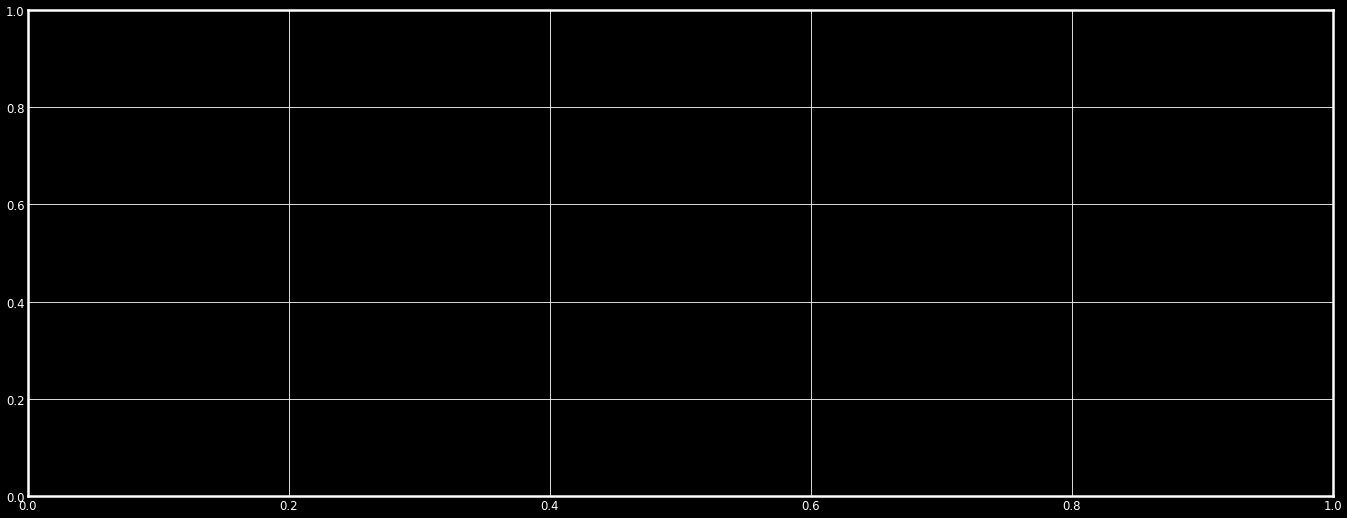

In [715]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 10), dpi= 60)
fig = plt.plot(range(1, 61, 10), scores)
plt.title('Bigram Model')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

In [339]:
from CTADaily import get_coherence_scores
models, scores = get_coherence_scores(bigrams, corpus, dictionary, range(4, 11, 1))

Building Model with 4 #Topics
Coherence 0.4182150846377269
Building Model with 5 #Topics
Coherence 0.46410551037403264
Building Model with 6 #Topics
Coherence 0.4457142681107942
Building Model with 7 #Topics
Coherence 0.4197898375365309
Building Model with 8 #Topics
Coherence 0.4054417908941093
Building Model with 9 #Topics
Coherence 0.43692787435709224
Building Model with 10 #Topics
Coherence 0.44134496281580216


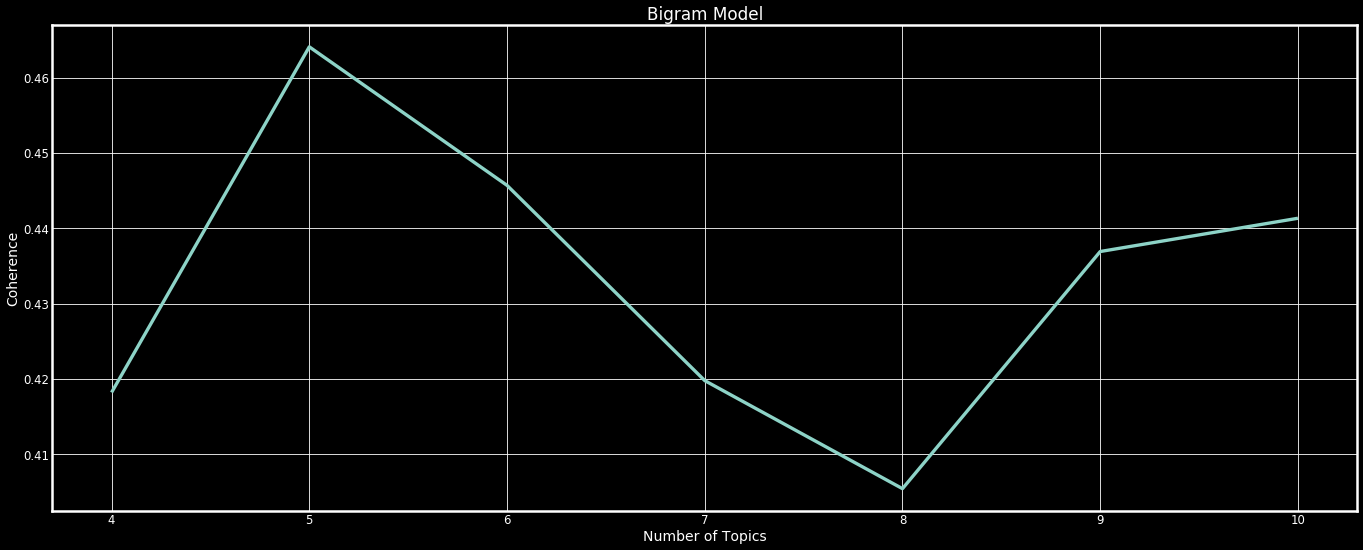

In [716]:
plt.style.use('dark_background')
fig = plt.figure(figsize=(25, 10), dpi= 60)
fig = plt.plot(range(4, 11, 1), scores)
plt.title('Bigram Model')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

In [362]:
max_idx = scores.index(max(scores))
num_topics = 4 + max_idx
lda_model = models[max_idx]
scores[max_idx]

0.46410551037403264

### Visualising Topics

In [710]:
import pyLDAvis
import pyLDAvis.gensim
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
pyLDAvis.enable_notebook()
model = malletmodel2ldamodel(lda_model)
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

C:\Users\Yash\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.000598 -0.000224       1        1  20.108903
1      0.000274 -0.000934       2        1  20.052620
3     -0.000425  0.000620       3        1  20.052046
2     -0.000188  0.000106       4        1  19.909048
0      0.000938  0.000432       5        1  19.877383, topic_info=      Category      Freq             Term     Total  loglift  logprob
term                                                                 
12606  Default  6.000000       drop_point  6.000000  30.0000  30.0000
2402   Default  6.000000        blackrock  6.000000  29.0000  29.0000
5454   Default  6.000000     share_advanc  6.000000  28.0000  28.0000
10110  Default  6.000000      profit_soar  6.000000  27.0000  27.0000
1538   Default  6.000000           suncor  6.000000  26.0000  26.0000
4031   Default  6.000000        bode_well  6.000000  25.0000  25.0000
12654  Default  6.000000             evoo  6.000000  24.0000  24.0000
2618   Default  6.000000    increas_prove  6.000000  23.0000  23.0000
6953   Default  5.000000           declar  5.000000  22.0000  22.0000
14500  Default  5.000000              rex  5.000000  21.0000  21.0000
21179  Default  5.000000       guard_back  5.000000  20.0000  20.0000
16954  Default  5.000000               ul  5.000000  19.0000  19.0000
1914   Default  6.000000        full_year  6.000000  18.0000  18.0000
13753  Default  6.000000       price_push  6.000000  17.0000  17.0000
9472   Default  5.000000          mantega  5.000000  16.0000  16.0000
20162  Default  6.000000      airlin_hedg  6.000000  15.0000  15.0000
9214   Default  6.000000         gilbarco  6.000000  14.0000  14.0000
10635  Default  5.000000  properti_equiti  5.000000  13.0000  13.0000
21283  Default  5.000000         new_cycl  5.000000  12.0000  12.0000
9225   Default  6.000000           enviro  6.000000  11.0000  11.0000
11963  Default  6.000000         king_say  6.000000  10.0000  10.0000
12548  Default  6.000000            enmor  6.000000   9.0000   9.0000
2485   Default  6.000000             goal  6.000000   8.0000   8.0000
14478  Default  6.000000      column_iran  6.000000   7.0000   7.0000
7866   Default  6.000000  kurdistan_focus  6.000000   6.0000   6.0000
4118   Default  5.000000            itali  5.000000   5.0000   5.0000
3072   Default  5.000000         hire_new  5.000000   4.0000   4.0000
4826   Default  6.000000               ab  6.000000   3.0000   3.0000
8812   Default  5.000000      cheaper_oil  5.000000   2.0000   2.0000
11709  Default  6.000000     commerci_van  6.000000   1.0000   1.0000
...        ...       ...              ...       ...      ...      ...
15138   Topic5  1.455326       naphthalen  5.855251   0.2235  -9.7749
5867    Topic5  1.445008        contribut  5.825913   0.2214  -9.7820
1742    Topic5  1.514273             opec  6.106913   0.2211  -9.7352
968     Topic5  1.482722         canadian  5.983312   0.2205  -9.7563
15525   Topic5  1.432074           saipem  5.787847   0.2190  -9.7910
6329    Topic5  1.495017    market_balanc  6.052607   0.2172  -9.7480
19969   Topic5  1.407048        tax_north  5.698260   0.2169  -9.8087
12835   Topic5  1.576586  collaps_foreign  6.386277   0.2167  -9.6949
9225    Topic5  1.518678           enviro  6.158564   0.2156  -9.7323
12393   Topic5  1.488626      slash_shale  6.046783   0.2139  -9.7523
17555   Topic5  1.548334           jacket  6.289326   0.2139  -9.7130
15106   Topic5  1.549099       halt_libya  6.329654   0.2080  -9.7125
2267    Topic5  1.538662              los  6.308767   0.2046  -9.7192
15211   Topic5  1.552673     princ_rupert  6.396105   0.1999  -9.7102
10464   Topic5  1.562827           vienna  6.465355   0.1956  -9.7037
7188    Topic5  1.572902              kog  6.597135   0.1819  -9.6972
6739    Topic5  1.555089       group_nest  6.496294   0.1859  -9.7086
13901   Topic5  1.556034          valerus  6.509922   0.1844  -9.7080
19223   T

### Regression Model

We will now be able to get the topic distribution for each document. We want to use these probabilities as features for our regression, combined with the date the headline was published by Reuters. We will need to unpack the tuples, to remove the topic number and only give us the probability. We will do this for all columns before merging date

In [346]:
import pandas
topic_dist_df = pandas.DataFrame(lda_model[corpus])

for column in topic_dist_df.columns:
    topic_dist_df[column] = topic_dist_df[column].apply(lambda x : x[1])

In [347]:
topic_dist_df.head(2)

,0,1,2,3,4
0,0.181818,0.200000,0.214141,0.200000,0.204040
1,0.188679,0.188679,0.188679,0.188679,0.245283


In [348]:
dates = pandas.read_csv('WTI-NEWS.csv')['Date']
topic_dist_df = pandas.concat([dates, topic_dist_df], axis=1, sort=False)

In [349]:
topic_dist_df.head(2)

,Date,0,1,2,3,4
0,2014-01-02,0.181818,0.200000,0.214141,0.200000,0.204040
1,2014-01-02,0.188679,0.188679,0.188679,0.188679,0.245283


Now we will merge the WTI Crude Oil Prices from our exported historical data. We have more dates in that dataset than the range of the dates from our headlines. Hence, we will perform an inner join between them on the matching column 'Date'. However, instead of using the raw price we will use a dummy variable to convert the price from a continous variable to a binary variable. 

#### Dummy Variable

It would be a lot more challenging to be able to use a text data set to predict a variable such as price, due to it's volatile nature especially for a commodity. This would require a much more sophisticated setup than the one provided here. Whilst not impossible, I would require something used in class such as Iterative Topic Modelling with Time Series Feedback to really create strong topic vectors such that we could then use the topic distribution and the word distribution within that to perform time series prediction. However, for this project the main aim will be to look at a document. Calculate it's topic distribution and tell the user whether it is a up or down day for that commodity, much like sentiment analysis. 

In [350]:
wti_prices = pandas.read_csv('DCOILWTICO.csv')

Let's shift our price vector ahead one day and see if that price is higher

In [351]:
wti_prices['Movement'] = (wti_prices['DCOILWTICO'] > wti_prices['DCOILWTICO'].shift(+1)).astype(int)

In [352]:
wti_prices['DCOILWTICO'].head(5)

0    98.32
1    97.25
2    97.21
3    96.27
4    97.18
Name: DCOILWTICO, dtype: object

In [353]:
wti_prices['Movement'].head(5)

0    0
1    0
2    0
3    0
4    1
Name: Movement, dtype: int32

We will now merge on date and only include price movement. 

In [686]:
topic_prices = pandas.merge(topic_dist_df, wti_prices[['Date', 'Movement']], on='Date')

In [687]:
topic_prices.head(2)

,Date,0,1,2,3,4,Movement
0,2014-01-02,0.181818,0.200000,0.214141,0.200000,0.204040,1
1,2014-01-02,0.188679,0.188679,0.188679,0.188679,0.245283,1


In [688]:
columns = ['Date'] + ['Topic {}'.format(i) for i in range(num_topics)] + ['Movement']
topic_prices.columns = columns

Let's save this to a file for easier analysis.

In [440]:
topic_prices.to_csv('WTI-LDA-TOPIC.csv', index=False)

#### Autocorrelation

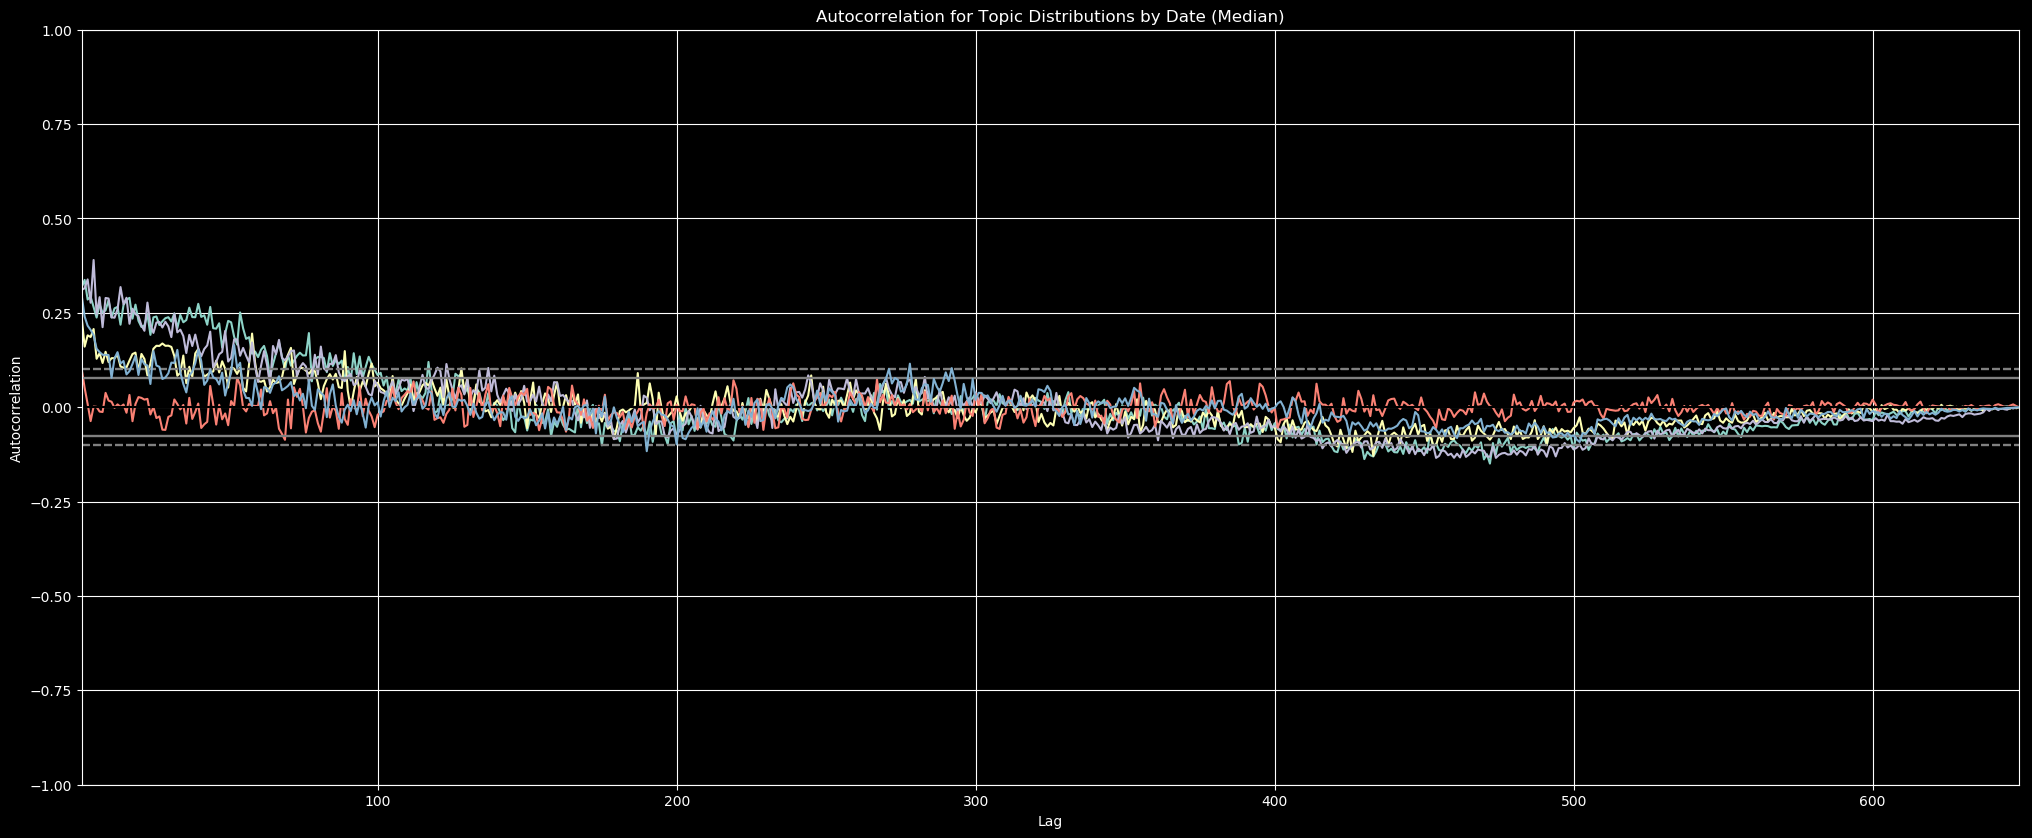

In [441]:
from pandas.plotting import autocorrelation_plot

topic_list = ['Topic {}'.format(i) for i in range(num_topics)]

fig = plt.figure(figsize=(25, 10), dpi=100)
for topic in topic_list:
    autocorrelation_plot(topic_prices[['Date', topic]].groupby('Date').median()[topic])
plt.title('Autocorrelation for Topic Distributions by Date (Median)')
plt.show()

This shows that there is significant autocorrelation within the topic itself over time, which makes intuitive sense. This last a long period of time, we can see only after about 50 periods does this autocorrelation become acceptable.

In [668]:
topic_medians = pandas.DataFrame()
for topic in topic_list:
    topic_medians[topic] = topic_prices[['Date', topic]].groupby('Date').median()[topic]

#### Train and Test Split

We can't randomly sample training and testing data, as this is a time series dataset. We would not provide a robust model by looking ahead. Therefore, we would want to allow for chronological order whilst splitting the data into a training and test set. 

In [669]:
topic_medians['Date'] = topic_medians.index
data_set = pandas.merge(topic_medians, wti_prices, on='Date')
X = data_set[topic_list]
y = data_set['Movement']

C:\Users\Yash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2961: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [670]:
num_obs = len(data_set)
split = int(0.8*num_obs)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [671]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Movement   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     86.27
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           9.45e-66
Time:                        22:44:26   Log-Likelihood:                -374.90
No. Observations:                 519   AIC:                             759.8
Df Residuals:                     514   BIC:                             781.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Topic 0       -0.0117      2.741     -0.004      0.997      -5.397       5.374
Topic 1       -0.3333      2.338     -0.143      0.887      -4.926       4.259
Topic 2       -0.3903      1.979     -0.197      0.844      -4.278       3.498
Topic 3        1.1647      2.069      0.563      0.574      -2.900       5.229
Topic 4        1.8854      1.915      0.984      0.325      -1.878       5.648
==============================================================================
Omnibus:                        2.625   Durbin-Watson:                   2.266
Prob(Omnibus):                  0.269   Jarque-Bera (JB):               85.932
Skew:                           0.173   Prob(JB):                     2.19e-19
Kurtosis:                       1.037   Cond. No.                         62.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [680]:
X_new = topic_prices[topic_list]
y_new = topic_prices['Movement']

num_obs = len(X_new)
split = int(0.8*num_obs)

In [681]:
print('Using all documents now, with observation count : {}'.format(num_obs))

Using all documents now, with observation count : 17715


In [682]:
X_new_train, X_new_test = X_new[:split], X_new[split:]
y_new_train, y_new_test = y_new[:split], y_new[split:]

from sklearn import svm
clf = svm.SVC()
clf.fit(X_new_train.values, y_new_train.values)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [683]:
svm_accuracy = clf.score(X_new_test.values, y_new_test.values)
print('SVM Accuracy {:.2f}%'.format(svm_accuracy*100))

SVM Accuracy 44.91%


In [684]:
clf = svm.SVC()
clf.fit(X_train.values, y_train.values)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [685]:
svm_accuracy = clf.score(X_test.values, y_test.values)
print('SVM Accuracy {:.2f}%'.format(svm_accuracy*100))

SVM Accuracy 46.92%
